In [3]:
%pip install yfinance
%pip install forex-python
%pip install matplotlib
%pip install scikit-learn
%pip install alpha_vantage
%pip install requests
%pip install currencyapicom
%pip install seaborn
%pip install scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import yfinance as yf
import pandas as pd
from functools import reduce
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from datetime import date, timedelta
import matplotlib.pyplot as plt
from forex_python.converter import CurrencyRates
from alpha_vantage.timeseries import TimeSeries
import requests
import currencyapicom
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

In [5]:
# Ensuring that the timestamps for oil and the other economic factors line up. We want each oil datapoint to be associated with the correct economic factor datapoint. If oil has a data point at a specific date and the economic factor does not, we will interpolate the economic data point or drop it.

# Oil and Natural Gas
# Natural Gas already lined up properly
oil = pd.read_csv('data/oil_data.csv') 
ng = pd.read_csv('data/natural_gas_data.csv')

In [6]:
# Oil vs Euro Value
oil = pd.read_csv('data/oil_data.csv')

eur = pd.read_csv('data/eur_data.csv')
eur = eur.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
oil = oil.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)

# Convert 'Date' columns to datetime data type
eur['Date'] = pd.to_datetime(eur['Date'])
oil['Date'] = pd.to_datetime(oil['Date'])

# Sort the 'Date' column in both DataFrames
eur.sort_values(by='Date', inplace=True)
oil.sort_values(by='Date', inplace=True)

# Merge ng data into eur, keeping the chronological order
eur = pd.merge_asof(eur, oil, on='Date', direction='forward', suffixes=('', '_oil'))

# Filter rows in eur that are not in ng
eur = eur.dropna(subset=['Price_oil'])

# Drop the 'Price_ng' column as it's no longer needed
eur = eur.drop('Price_oil', axis=1)

# Keep only date values present in ng
eur = eur[eur['Date'].isin(oil['Date'])]

# Add rows from ng that are missing in eur
missing_dates_mask = ~oil['Date'].isin(eur['Date'])
missing_rows = oil[missing_dates_mask]

# Concatenate missing rows to eur
eur = pd.concat([eur, missing_rows], ignore_index=True)

# Sort the DataFrame by the 'Date' column
eur.sort_values(by='Date', inplace=True)

# Reset the index
eur.reset_index(drop=True, inplace=True)

In [7]:
# Oil and Gold
import pandas as pd
import numpy as np

# Load gold data
gold = pd.read_csv('data/gold_data.csv')

# Convert 'Date' column to datetime data type
gold['Date'] = pd.to_datetime(gold['Date'])

# Drop unnecessary columns from gold DataFrame
gold = gold[['Date', 'Price']]

# Set 'Date' column as the index for gold DataFrame
gold.set_index('Date', inplace=True)

# Sort the 'Date' index in the gold DataFrame
gold.sort_index(inplace=True)

# Load oil data
oil = pd.read_csv("data/oil_data.csv")  # Replace with the correct file name
oil['Date'] = pd.to_datetime(oil['Date'])

# Set 'Date' column as the index for oil DataFrame
oil.set_index('Date', inplace=True)

# Sort the 'Date' index in the oil DataFrame
oil.sort_index(inplace=True)

# Remove rows in 'gold' that do not have corresponding dates in 'oil'
gold = gold[gold.index.isin(oil.index)]

# Merge gold data into oil, keeping the chronological order
merged_data = pd.merge_asof(gold, oil, left_index=True, right_index=True, direction='forward', suffixes=('_gold', '_oil'))

# Add rows with dates from 'oil' that are not in 'gold' and set 'Price_gold' to NaN
missing_dates = oil[~oil.index.isin(gold.index)]
missing_dates['Price_gold'] = np.nan
merged_data = pd.concat([merged_data, missing_dates], ignore_index=False)

# Sort the DataFrame by 'Date' after concatenation
merged_data.sort_index(inplace=True)
merged_data['Price_gold'] = merged_data['Price_gold'].replace(',', '', regex=True) # STRIPS comams for float conversion

# Convert 'Price_gold' and 'Price_oil' columns to numeric type
merged_data['Price_gold'] = pd.to_numeric(merged_data['Price_gold'], errors='coerce')
merged_data['Price_oil'] = pd.to_numeric(merged_data['Price_oil'], errors='coerce')

# Time series interpolation of missing values for gold 
merged_data['Price_gold'] = merged_data['Price_gold'].interpolate(method='time')

/var/folders/6p/ycgkpqkx6rd0xffcbwt9wg8w0000gn/T/ipykernel_25970/3044710277.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_dates['Price_gold'] = np.nan


In [8]:
# Oil and US Dollar

# Load dollar data
dollar = pd.read_csv('data/dollar_data.csv')

# Convert 'Date' column to datetime data type
dollar['Date'] = pd.to_datetime(dollar['Date'])

# Drop unnecessary columns from dollar DataFrame
dollar = dollar[['Date', 'Price']]

# Set 'Date' column as the index for dollar DataFrame
dollar.set_index('Date', inplace=True)

# Sort the 'Date' index in the dollar DataFrame
dollar.sort_index(inplace=True)

# Load oil data
oil = pd.read_csv("data/oil_data.csv")  # Replace with the correct file name
oil['Date'] = pd.to_datetime(oil['Date'])

# Set 'Date' column as the index for oil DataFrame
oil.set_index('Date', inplace=True)

# Sort the 'Date' index in the oil DataFrame
oil.sort_index(inplace=True)

# Remove rows in 'dollar' that do not have corresponding dates in 'oil'
dollar = dollar[dollar.index.isin(oil.index)]

# Merge dollar data into oil, keeping the chronological order
merged_data = pd.merge_asof(dollar, oil, left_index=True, right_index=True, direction='forward', suffixes=('_dollar', '_oil'))

# Add rows with dates from 'oil' that are not in 'dollar' and set 'Price_dollar' to NaN
missing_dates = oil[~oil.index.isin(dollar.index)]
missing_dates['Price_dollar'] = np.nan
merged_data = pd.concat([merged_data, missing_dates], ignore_index=False)

# Sort the DataFrame by 'Date' after concatenation
merged_data.sort_index(inplace=True)
merged_data['Price_dollar'] = merged_data['Price_dollar'].replace(',', '', regex=True) # STRIPS comams for float conversion

# Convert 'Price_dollar' and 'Price_oil' columns to numeric type
merged_data['Price_dollar'] = pd.to_numeric(merged_data['Price_dollar'], errors='coerce')
merged_data['Price_oil'] = pd.to_numeric(merged_data['Price_oil'], errors='coerce')

# Time series interpolation of missing values in the 'Price_dollar' column
merged_data['Price_dollar'] = merged_data['Price_dollar'].interpolate(method='time')

/var/folders/6p/ycgkpqkx6rd0xffcbwt9wg8w0000gn/T/ipykernel_25970/4141364857.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_dates['Price_dollar'] = np.nan


In [9]:
# Oil and Japananese Yen

# Load japan data
japan = pd.read_csv('data/japan_data.csv')

# Convert 'Date' column to datetime data type
japan['Date'] = pd.to_datetime(japan['Date'])

# Drop unnecessary columns from japan DataFrame
japan = japan[['Date', 'Price']]

# Set 'Date' column as the index for japan DataFrame
japan.set_index('Date', inplace=True)

# Sort the 'Date' index in the japan DataFrame
japan.sort_index(inplace=True)

# Load oil data
oil = pd.read_csv("data/oil_data.csv")  # Replace with the correct file name
oil['Date'] = pd.to_datetime(oil['Date'])

# Set 'Date' column as the index for oil DataFrame
oil.set_index('Date', inplace=True)

# Sort the 'Date' index in the oil DataFrame
oil.sort_index(inplace=True)

# Remove rows in 'japan' that do not have corresponding dates in 'oil'
japan = japan[japan.index.isin(oil.index)]

# Merge japan data into oil, keeping the chronological order
merged_data = pd.merge_asof(japan, oil, left_index=True, right_index=True, direction='forward', suffixes=('_japan', '_oil'))

# Add rows with dates from 'oil' that are not in 'japan' and set 'Price_japan' to NaN
missing_dates = oil[~oil.index.isin(japan.index)]
missing_dates['Price_japan'] = np.nan
merged_data = pd.concat([merged_data, missing_dates], ignore_index=False)

# Sort the DataFrame by 'Date' after concatenation
merged_data.sort_index(inplace=True)
merged_data['Price_japan'] = merged_data['Price_japan'].replace(',', '', regex=True) # STRIPS comams for float conversion

# Convert 'Price_japan' and 'Price_oil' columns to numeric type
merged_data['Price_japan'] = pd.to_numeric(merged_data['Price_japan'], errors='coerce')
merged_data['Price_oil'] = pd.to_numeric(merged_data['Price_oil'], errors='coerce')

# Time series interpolation of missing values in the 'Price_japan' column
merged_data['Price_japan'] = merged_data['Price_japan'].interpolate(method='time')

/var/folders/6p/ycgkpqkx6rd0xffcbwt9wg8w0000gn/T/ipykernel_25970/1988802534.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_dates['Price_japan'] = np.nan


In [10]:
# Oil and US Economy

# Load spy data
spy = pd.read_csv('data/spy.csv')

# Convert 'Date' column to datetime data type
spy['Date'] = pd.to_datetime(spy['Date'])

# Drop unnecessary columns from spy DataFrame
spy = spy[['Date', 'Price']]

# Set 'Date' column as the index for spy DataFrame
spy.set_index('Date', inplace=True)

# Sort the 'Date' index in the spy DataFrame
spy.sort_index(inplace=True)

# Load oil data
oil = pd.read_csv("data/oil_data.csv")  # Replace with the correct file name
oil['Date'] = pd.to_datetime(oil['Date'])

# Set 'Date' column as the index for oil DataFrame
oil.set_index('Date', inplace=True)

# Sort the 'Date' index in the oil DataFrame
oil.sort_index(inplace=True)

# Remove rows in 'spy' that do not have corresponding dates in 'oil'
spy = spy[spy.index.isin(oil.index)]

# Merge spy data into oil, keeping the chronological order
merged_data = pd.merge_asof(spy, oil, left_index=True, right_index=True, direction='forward', suffixes=('_spy', '_oil'))

# Add rows with dates from 'oil' that are not in 'spy' and set 'Price_spy' to NaN
missing_dates = oil[~oil.index.isin(spy.index)]
missing_dates['Price_spy'] = np.nan
merged_data = pd.concat([merged_data, missing_dates], ignore_index=False)

# Sort the DataFrame by 'Date' after concatenation
merged_data.sort_index(inplace=True)
merged_data['Price_spy'] = merged_data['Price_spy'].replace(',', '', regex=True) # STRIPS comams for float conversion

# Convert 'Price_spy' and 'Price_oil' columns to numeric type
merged_data['Price_spy'] = pd.to_numeric(merged_data['Price_spy'], errors='coerce')
merged_data['Price_oil'] = pd.to_numeric(merged_data['Price_oil'], errors='coerce')

# Time series interpolation of missing values in the 'Price_spy' column
merged_data['Price_spy'] = merged_data['Price_spy'].interpolate(method='time')

/var/folders/6p/ycgkpqkx6rd0xffcbwt9wg8w0000gn/T/ipykernel_25970/37043719.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_dates['Price_spy'] = np.nan


In [11]:
# Oil and Exxon/Chevron, biggest shale/alternative oil producers

# Load exxon data
exxon = pd.read_csv('data/exxon.csv')

# Convert 'Date' column to datetime data type
exxon['Date'] = pd.to_datetime(exxon['Date'])

# Drop unnecessary columns from exxon DataFrame
exxon = exxon[['Date', 'Price']]

# Set 'Date' column as the index for exxon DataFrame
exxon.set_index('Date', inplace=True)

# Sort the 'Date' index in the exxon DataFrame
exxon.sort_index(inplace=True)

# Load oil data
oil = pd.read_csv("data/oil_data.csv")  # Replace with the correct file name
oil['Date'] = pd.to_datetime(oil['Date'])

# Set 'Date' column as the index for oil DataFrame
oil.set_index('Date', inplace=True)

# Sort the 'Date' index in the oil DataFrame
oil.sort_index(inplace=True)

# Remove rows in 'exxon' that do not have corresponding dates in 'oil'
exxon = exxon[exxon.index.isin(oil.index)]

# Merge exxon data into oil, keeping the chronological order
merged_data = pd.merge_asof(exxon, oil, left_index=True, right_index=True, direction='forward', suffixes=('_exxon', '_oil'))

# Add rows with dates from 'oil' that are not in 'exxon' and set 'Price_exxon' to NaN
missing_dates = oil[~oil.index.isin(exxon.index)]
missing_dates['Price_exxon'] = np.nan
merged_data = pd.concat([merged_data, missing_dates], ignore_index=False)

# Sort the DataFrame by 'Date' after concatenation
merged_data.sort_index(inplace=True)
merged_data['Price_exxon'] = merged_data['Price_exxon'].replace(',', '', regex=True) # STRIPS comams for float conversion

# Convert 'Price_exxon' and 'Price_oil' columns to numeric type
merged_data['Price_exxon'] = pd.to_numeric(merged_data['Price_exxon'], errors='coerce')
merged_data['Price_oil'] = pd.to_numeric(merged_data['Price_oil'], errors='coerce')

# Time series interpolation of missing values in the 'Price_exxon' column
merged_data['Price_exxon'] = merged_data['Price_exxon'].interpolate(method='time')

/var/folders/6p/ycgkpqkx6rd0xffcbwt9wg8w0000gn/T/ipykernel_25970/1493880258.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_dates['Price_exxon'] = np.nan


In [12]:
# Oil and  US Treasury

# Load bond data
bond = pd.read_csv('data/bond.csv')

# Convert 'Date' column to datetime data type
bond['Date'] = pd.to_datetime(bond['Date'])

# Drop unnecessary columns from bond DataFrame
bond = bond[['Date', 'Price']]

# Set 'Date' column as the index for bond DataFrame
bond.set_index('Date', inplace=True)

# Sort the 'Date' index in the bond DataFrame
bond.sort_index(inplace=True)

# Load oil data
oil = pd.read_csv("data/oil_data.csv")  # Replace with the correct file name
oil['Date'] = pd.to_datetime(oil['Date'])

# Set 'Date' column as the index for oil DataFrame
oil.set_index('Date', inplace=True)

# Sort the 'Date' index in the oil DataFrame
oil.sort_index(inplace=True)

# Remove rows in 'bond' that do not have corresponding dates in 'oil'
bond = bond[bond.index.isin(oil.index)]

# Merge bond data into oil, keeping the chronological order
merged_data = pd.merge_asof(bond, oil, left_index=True, right_index=True, direction='forward', suffixes=('_bond', '_oil'))

# Add rows with dates from 'oil' that are not in 'bond' and set 'Price_bond' to NaN
missing_dates = oil[~oil.index.isin(bond.index)]
missing_dates['Price_bond'] = np.nan
merged_data = pd.concat([merged_data, missing_dates], ignore_index=False)

# Sort the DataFrame by 'Date' after concatenation
merged_data.sort_index(inplace=True)
merged_data['Price_bond'] = merged_data['Price_bond'].replace(',', '', regex=True) # STRIPS comams for float conversion

# Convert 'Price_bond' and 'Price_oil' columns to numeric type
merged_data['Price_bond'] = pd.to_numeric(merged_data['Price_bond'], errors='coerce')
merged_data['Price_oil'] = pd.to_numeric(merged_data['Price_oil'], errors='coerce')

# Time series interpolation of missing values in the 'Price_bond' column
merged_data['Price_bond'] = merged_data['Price_bond'].interpolate(method='time')

/var/folders/6p/ycgkpqkx6rd0xffcbwt9wg8w0000gn/T/ipykernel_25970/1634552232.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_dates['Price_bond'] = np.nan


Pearson correlation coefficient: -0.5985852491476537
P-value: 0.0


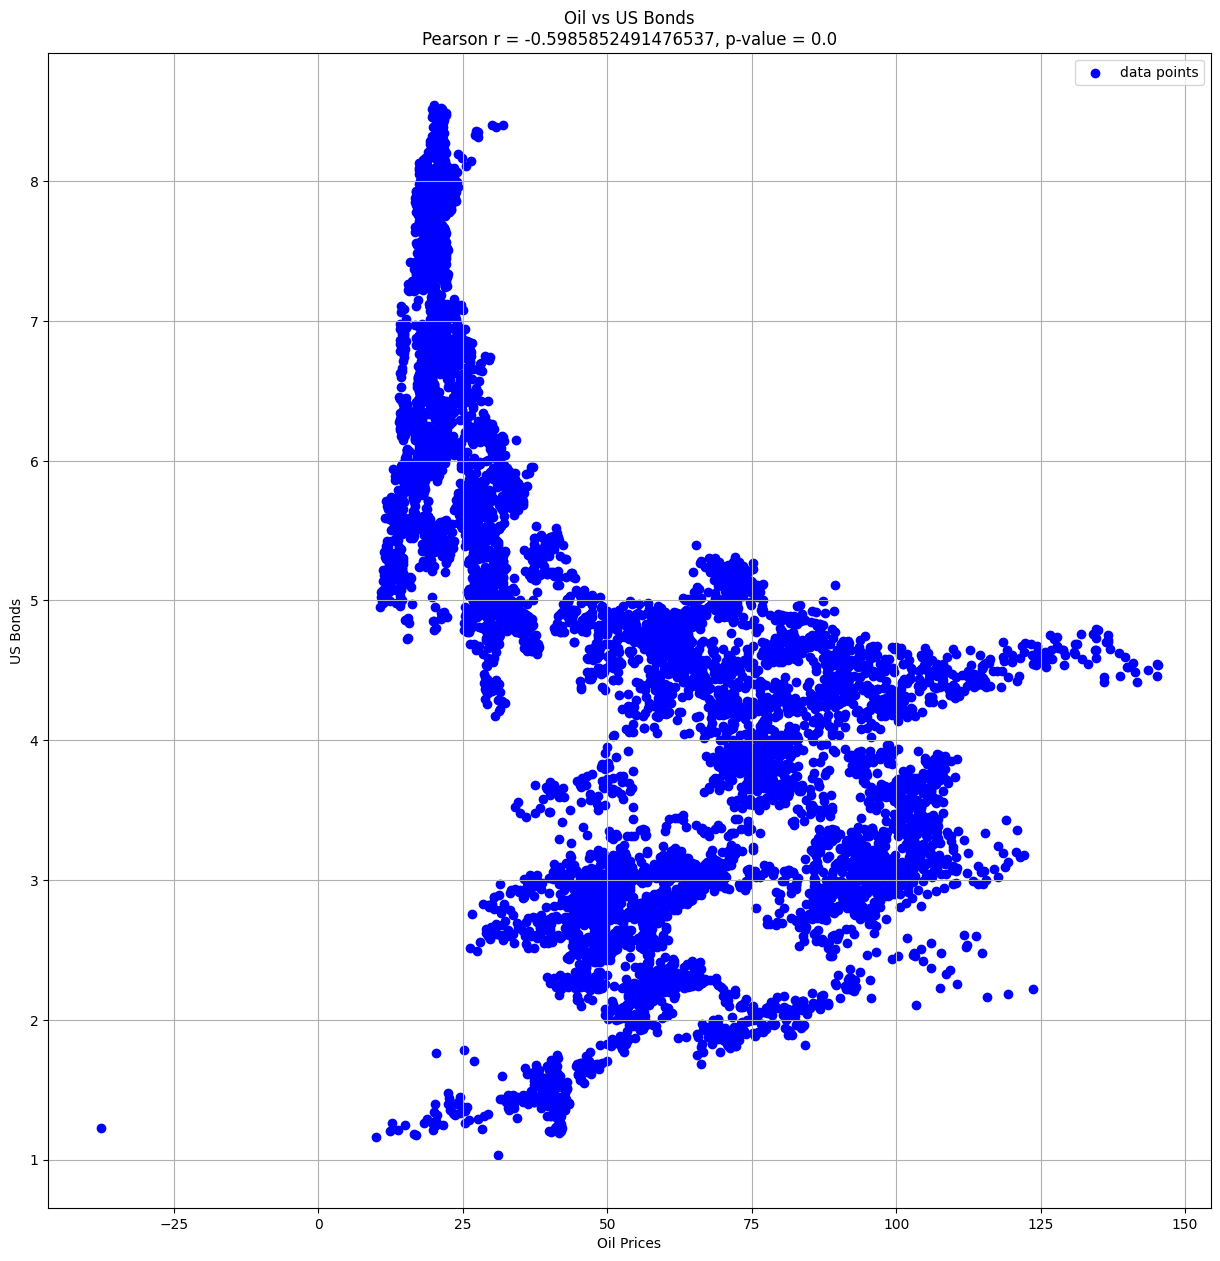

Spearman correlation coefficient: -0.41738475670874364
P-value: 0.0


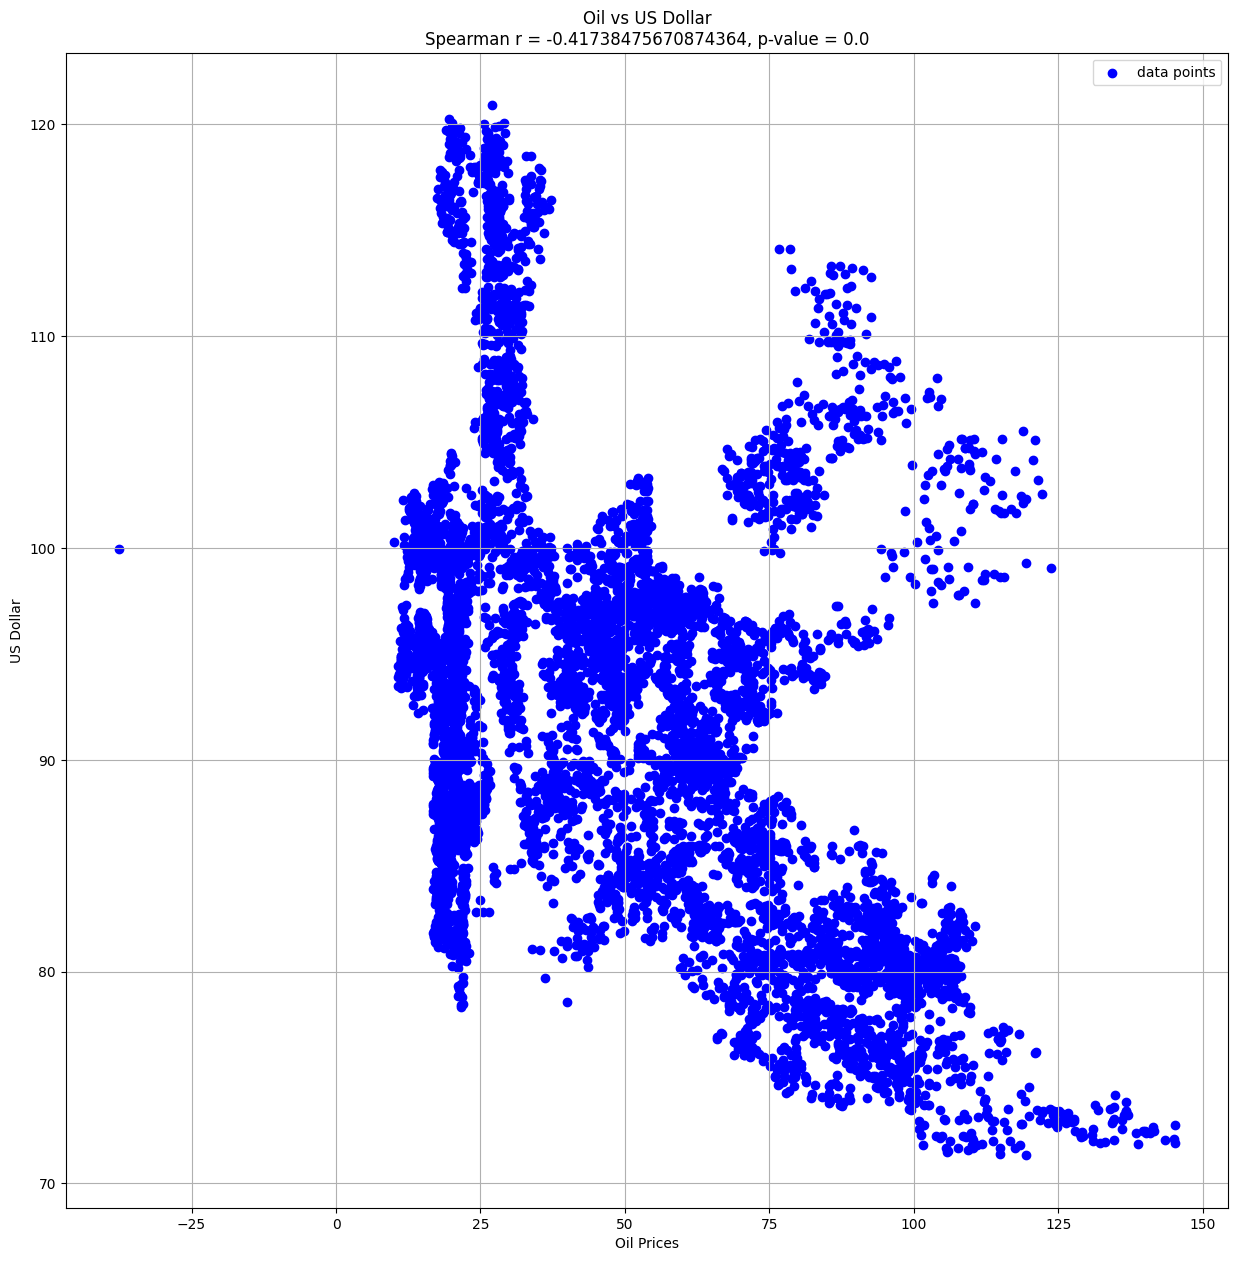

Pearson correlation coefficient: 0.8371462583248163
P-value: 0.0


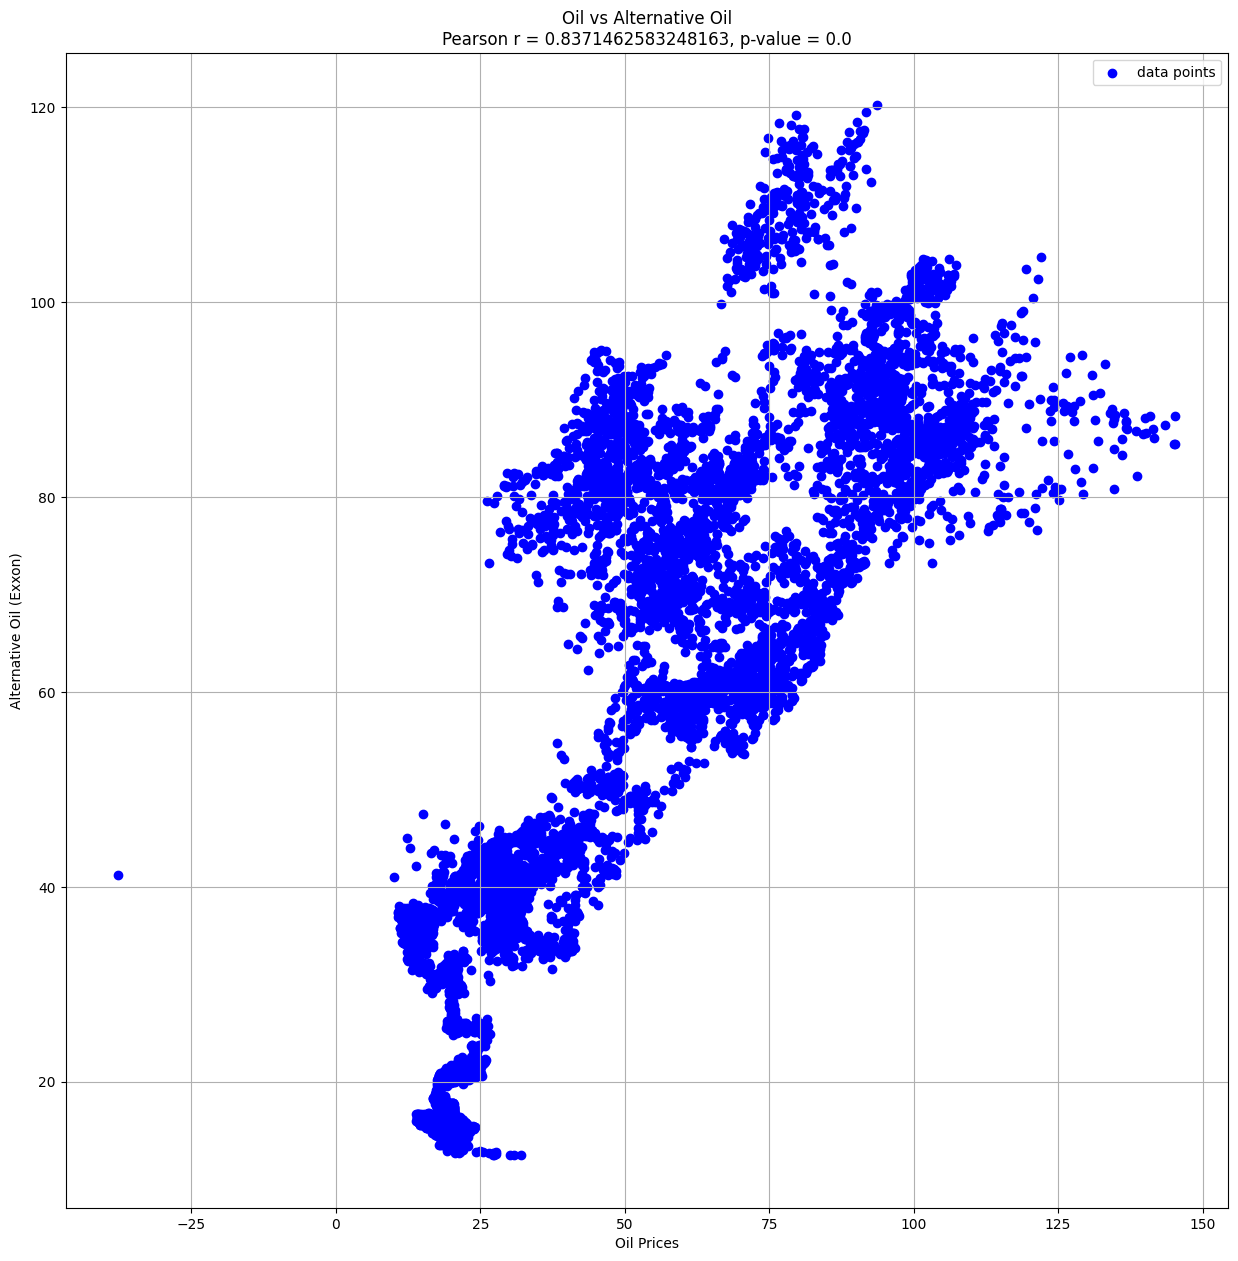

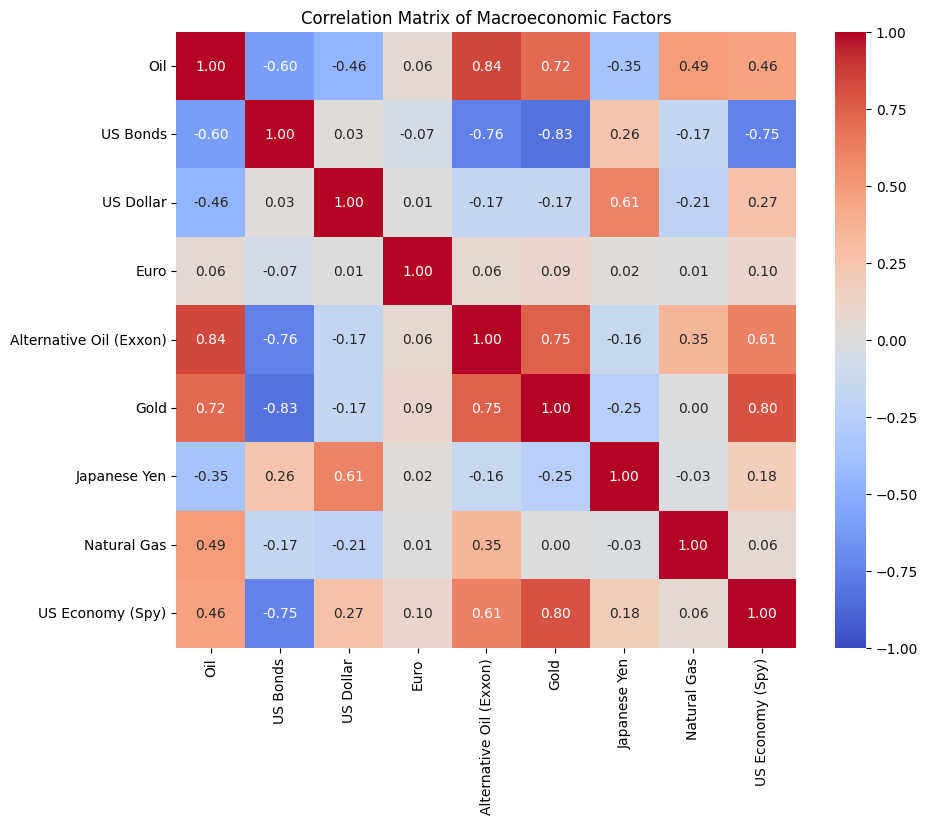

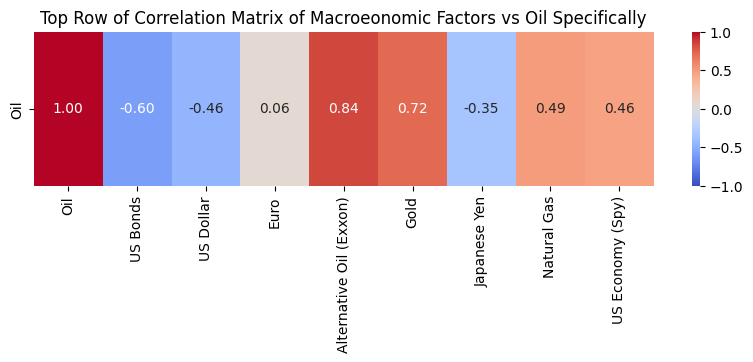

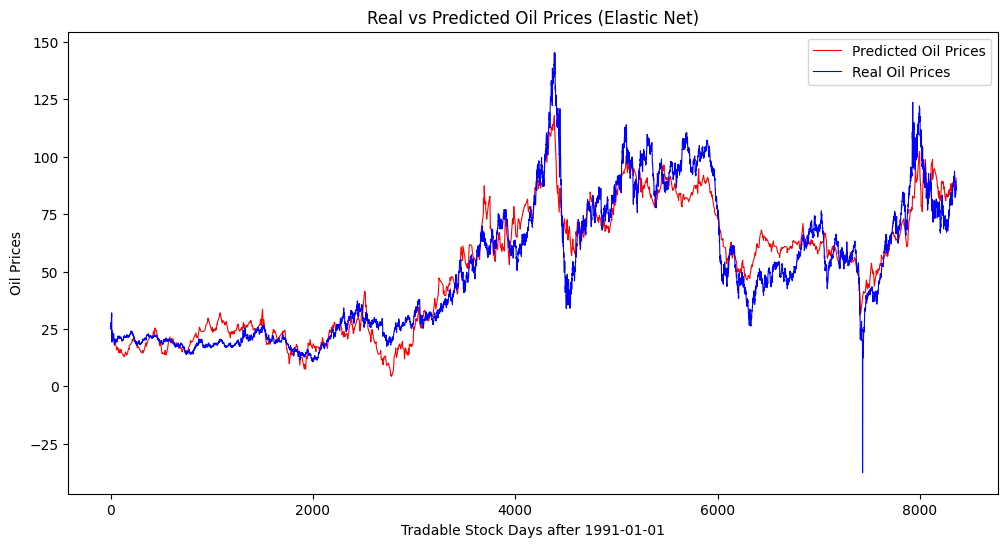

Mean Squared Error: 87.7050713955192
R-squared: 0.9002158537261145
Time Series Cross-Val Mean Squared Error: [34.36423578611308, 81.43223923275082, 132.0438491755038, 156.22180839839578, 98.90077627968168]
Time Series Cross-Val R-squared: [0.04362481848806987, 0.6915861442403776, 0.654891564646737, 0.7151475604322173, 0.756100816830216]


In [ ]:
# Data cleaning and interpolation sections can be found below this code box

# 8 macroeconomic factors analyzed (US Bonds, US Dollar, US Economy, Gold, Euro, Japanese Yen, Natural Gas, Shale/Alternative Oil)
oil = pd.read_csv('interpolated_data/oil.csv') # Crude Oil (WTI)
bond = pd.read_csv('interpolated_data/bond_interpolated.csv') # US Bonds
dollar = pd.read_csv('interpolated_data/dollar_interpolated.csv') # US Dollar
euro = pd.read_csv('interpolated_data/euro_interpolated.csv') # Euro
exxon = pd.read_csv('interpolated_data/exxon_interpolated.csv') # Shale/Alternative Oil
gold = pd.read_csv('interpolated_data/gold_interpolated.csv') # Gold
yen = pd.read_csv('interpolated_data/japan_interpolated.csv') # Japanese Yen
ng = pd.read_csv('interpolated_data/ng_interpolated.csv') # Natural Gas
spy = pd.read_csv('interpolated_data/spy_interpolated.csv') # US Economy

# Concatenate DataFrames along the columns
merged_data = pd.concat([oil['Oil'], 
                         bond['US Bonds'], 
                         dollar['US Dollar'], 
                         euro['Euro'], 
                         exxon['Alternative Oil (Exxon)'], 
                         gold['Gold'], 
                         yen['Japanese Yen'], 
                         ng['Natural Gas'], 
                         spy['US Economy (Spy)']], axis=1)



# Pearson correlation test for oil and bonds
corr, p = pearsonr(oil['Oil'],  bond['US Bonds'])
 
print("Pearson correlation coefficient:", corr)
print(f"P-value: {p}")

plt.figure(figsize=(15, 15))
plt.scatter(oil['Oil'], bond['US Bonds'], color='blue', label='data points')

plt.xlabel('Oil Prices')
plt.ylabel('US Bonds')
plt.title(f"Oil vs US Bonds\nPearson r = {corr}, p-value = {p}")
plt.legend()
plt.grid(True)
plt.show()
# CONCLUSION
# Since we have a  Person correlation of approximately -0.6 and a p-value of 0, we can conclude that there is a moderate negative correlation between oil prices and US bonds.

# Spearman's correlation test for oul and US dollar
corr, p = spearmanr(oil['Oil'], dollar['US Dollar'])

print("Spearman correlation coefficient:", corr)
print(f"P-value: {p}")

plt.figure(figsize=(15, 15))
plt.scatter(oil['Oil'], dollar['US Dollar'], color='blue', label='data points')

plt.xlabel('Oil Prices')
plt.ylabel('US Dollar')
plt.title(f"Oil vs US Dollar\nSpearman r = {corr}, p-value = {p}")
plt.legend()
plt.grid(True)
plt.show()
# CONCLUSION
# Since we have a Spearman correlation of approximately -0.417 and a p-value of 0, we can conclude that there is a negative correlation between oil prices and US bonds.

# Pearson correlation test for oil and alternative oil 
corr, p = pearsonr(oil['Oil'],  exxon['Alternative Oil (Exxon)'])
 
print("Pearson correlation coefficient:", corr)
print(f"P-value: {p}")

plt.figure(figsize=(15, 15))
plt.scatter(oil['Oil'], exxon['Alternative Oil (Exxon)'], color='blue', label='data points')

plt.xlabel('Oil Prices')
plt.ylabel('Alternative Oil (Exxon)')
plt.title(f"Oil vs Alternative Oil\nPearson r = {corr}, p-value = {p}")
plt.legend()
plt.grid(True)
plt.show()
# CONCLUSION
# Since we have a Person correlation of approximately 0.837 and a p-value of 0, we can conclude that there is a significant postive correlation between oil prices and alternative oils such as shale.


# Calculate the correlation matrix
correlation_matrix = merged_data.corr()
# correlation matrix with a heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix of Macroeconomic Factors')
plt.show()

#  top row of the correlation matrix for ease of understanding 
plt.figure(figsize=(10, 2))
sns.heatmap(correlation_matrix.iloc[:1, :], annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Top Row of Correlation Matrix of Macroeonomic Factors vs Oil Specifically')
plt.show()

# Conclusion
# From the top‐row correlations displayed, Oil has its highest positive relationship with Exxon (around +0.84) and a moderately strong positive relationship with Gold (around +0.72). In contrast, US Bonds show a notably strong negative correlation with Oil (around −0.60), and the US Dollar is also negatively correlated (around −0.46). Meanwhile, the Euro exhibits almost no linear relationship with Oil (near zero). 

# Elstic Net Regression Model using the eight macroeconomic factors (The model combines both lasso and ridge regression)
# Select the features (X) and target variable (y)
X = merged_data.drop(['Oil'], axis=1)  # Assuming 'Date' is not a predictor
y = merged_data['Oil']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Elastic Net model
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.7)  # Adjust alpha and l1_ratio as needed for penalties
elastic_net.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = elastic_net.predict(X_test_scaled)

# Sorting the predicted values since the data is time series based
sorted_indices = X_test.index.argsort()
X_test_sorted = X_test.iloc[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

# Plotting the predicted oil prices
plt.figure(figsize=(12, 6))
plt.plot(X_test_sorted.index, y_pred_sorted, label='Predicted Oil Prices', linestyle='-', linewidth=.8, color='red') 

# Plotting the real oil prices (they were actually negative at some point in April 2020!)
plt.plot(merged_data['Oil'], label='Real Oil Prices', linestyle='-', linewidth=.8, color='blue') 

plt.title('Real vs Predicted Oil Prices (Elastic Net)')
plt.xlabel('Tradable Stock Days after 1991-01-01')
plt.ylabel('Oil Prices')
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Define the time series split across 5 intervals
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed

# Initialize metrics for evaluation
all_mse = []
all_r2 = []

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Standardize the features using the same scaler from the original model
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Make predictions on the test set
    y_pred = elastic_net.predict(X_test_scaled)

    # Evaluate the model and store metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    all_mse.append(mse)
    all_r2.append(r2)

print(f'Time Series Cross-Val Mean Squared Error: {all_mse}')
print(f'Time Series Cross-Val R-squared: {all_r2}')
